In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
import scipy.stats as stats
from scipy.stats import gaussian_kde
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
dat_wide = pd.read_csv("../data/region_patients_wide.csv")
print(dat_wide.head())

   location_1  location_2  location_3  location_4  location_5
0          12           7           7           8          15
1          12           4           6           9          10
2           6           6           9           7          12
3          13           9           6          14          10
4          12           3          15           6           6


In [4]:
dat_wide.shape

(30, 5)

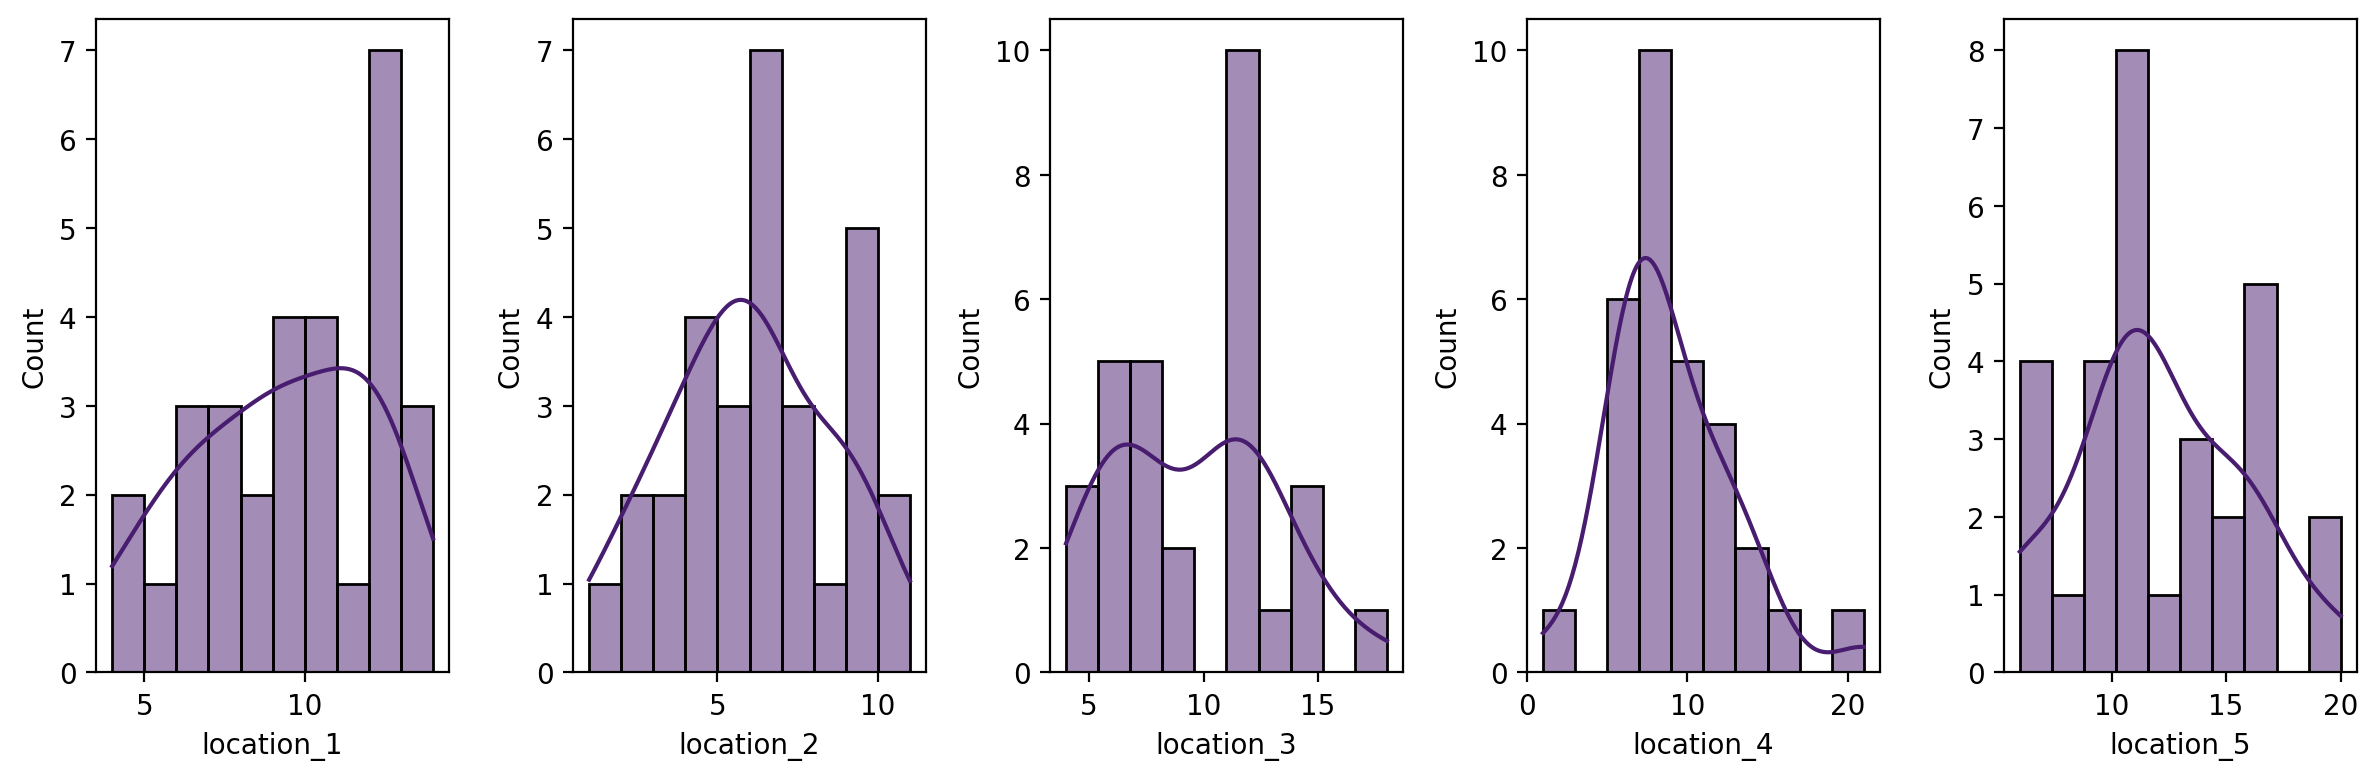

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=len(dat_wide.columns), figsize=(12, 4))

for i, col in enumerate(dat_wide.columns):
    sns.histplot(
        dat_wide[col], bins=10, kde=True, ax=axes[i]
    )  

plt.tight_layout()
plt.show()

In [6]:
# Fare una copia così da non cambiare il DataFrame originale
dw = dat_wide.copy()

# Reset dell'indice per utilizzarlo come una colonna
dw.reset_index(inplace=True)

# Convertire il DataFrame in formato long utilizzando melt
dat_long = pd.melt(dw, id_vars=['index'], var_name='location', value_name='patients')

# Rinominare la colonna 'index' in 'obs' per maggiore chiarezza
dat_long.rename(columns={'index': 'obs'}, inplace=True)

# Visualizzare il DataFrame risultante
print(dat_long)

     obs    location  patients
0      0  location_1        12
1      1  location_1        12
2      2  location_1         6
3      3  location_1        13
4      4  location_1        12
..   ...         ...       ...
145   25  location_5        11
146   26  location_5        11
147   27  location_5        19
148   28  location_5        11
149   29  location_5        15

[150 rows x 3 columns]


In [7]:
with pm.Model() as model_pooling:
    y_data = pm.ConstantData("y_data", dat_long["patients"])
    h_mu = pm.HalfNormal("h_mu", sigma=10)
    h_sigma = pm.HalfNormal("h_sigma", sigma=20)
    rate = pm.Gamma("rate", mu=h_mu, sigma=h_sigma)
    y_obs = pm.Poisson("y_obs", mu=rate, observed=y_data)

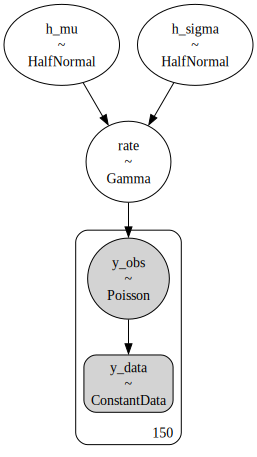

In [8]:
pm.model_to_graphviz(model_pooling)

In [9]:
with model_pooling:
    idata_pooling_prior_pred = pm.sample_prior_predictive(samples=100, random_seed=rng)

Sampling: [h_mu, h_sigma, rate, y_obs]


In [10]:
idata_pooling_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [11]:
foo = idata_pooling_prior_pred.prior_predictive.y_obs
foo.shape

(1, 100, 150)

In [12]:
# Extract the likelihood samples
likelihood_samples = idata_pooling_prior_pred.prior_predictive.y_obs
flattened_array = np.ravel(likelihood_samples.values)

print(flattened_array)

[ 0  0  0 ... 14 10 14]


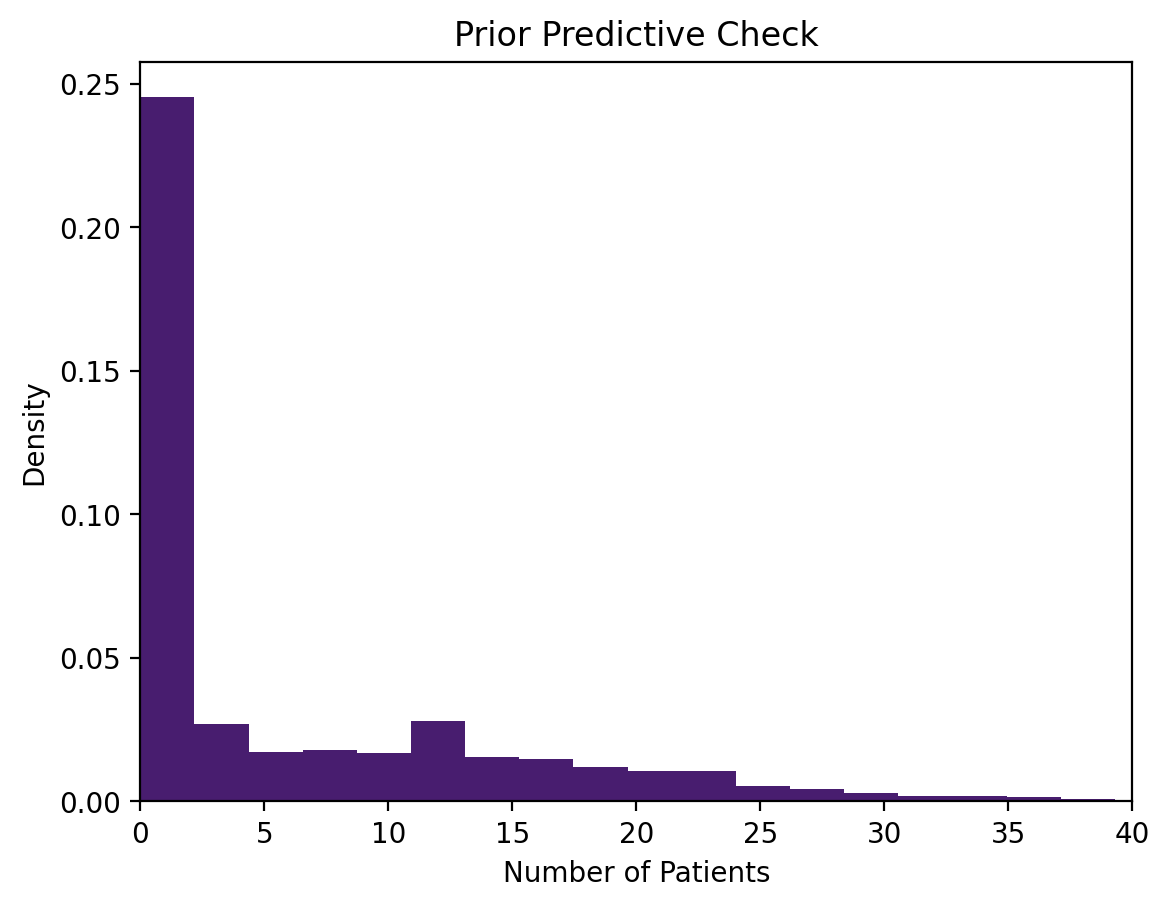

In [13]:
# Plot the prior predictive samples
plt.hist(flattened_array, bins=60, density=True)
plt.xlabel('Number of Patients')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.xlim(0, 40)
plt.show()

In [14]:
with model_pooling:
    idata_pooling = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:02.490385
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.792171
Transforming variables...
Transformation time =  0:00:00.018741
Computing Log Likelihood...


Log Likelihood time =  0:00:00.351162


In [15]:
az.summary(idata_pooling)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h_mu,10.415,4.482,2.554,19.011,0.101,0.072,1771.0,1502.0,1.0
h_sigma,9.297,8.308,0.449,24.959,0.204,0.144,868.0,490.0,1.0
rate,9.161,0.243,8.700,9.609,0.005,0.004,2328.0,2065.0,1.0


In [16]:
dat_wide.head()

,location_1,location_2,location_3,location_4,location_5
0,12,7,7,8,15
1,12,4,6,9,10
2,6,6,9,7,12
3,13,9,6,14,10
4,12,3,15,6,6


In [17]:
# The data has two dimensions: obs and location
# The "coordinates" are the unique values that these dimensions can take
coords = {"obs": dat_wide.index, "location": dat_wide.columns}
display(coords)

{'obs': RangeIndex(start=0, stop=30, step=1),
 'location': Index(['location_1', 'location_2', 'location_3', 'location_4', 'location_5'], dtype='object')}

In [18]:
with pm.Model(coords=coords) as model_h:
    # Definizione dei dati
    data = pm.ConstantData("observed_score", dat_wide, dims=("obs", "location"))

    # Iperparametri per la distribuzione Gamma
    h_mu = pm.HalfNormal("h_mu", sigma=10)
    h_sigma = pm.HalfNormal("h_sigma", sigma=20)

    # Priori Gamma per ogni località
    lam = pm.Gamma("lam", mu=h_mu, sigma=h_sigma, dims="location")

    # Verosimiglianza Poissoniana per i punteggi
    score = pm.Poisson("score", mu=lam, observed=data, dims=("obs", "location"))

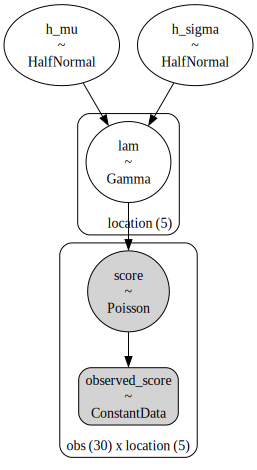

In [19]:
pm.model_to_graphviz(model_h)

In [20]:
with model_h:
    idata_h_prior_pred = pm.sample_prior_predictive()

Sampling: [h_mu, h_sigma, lam, score]


In [21]:
idata_h_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

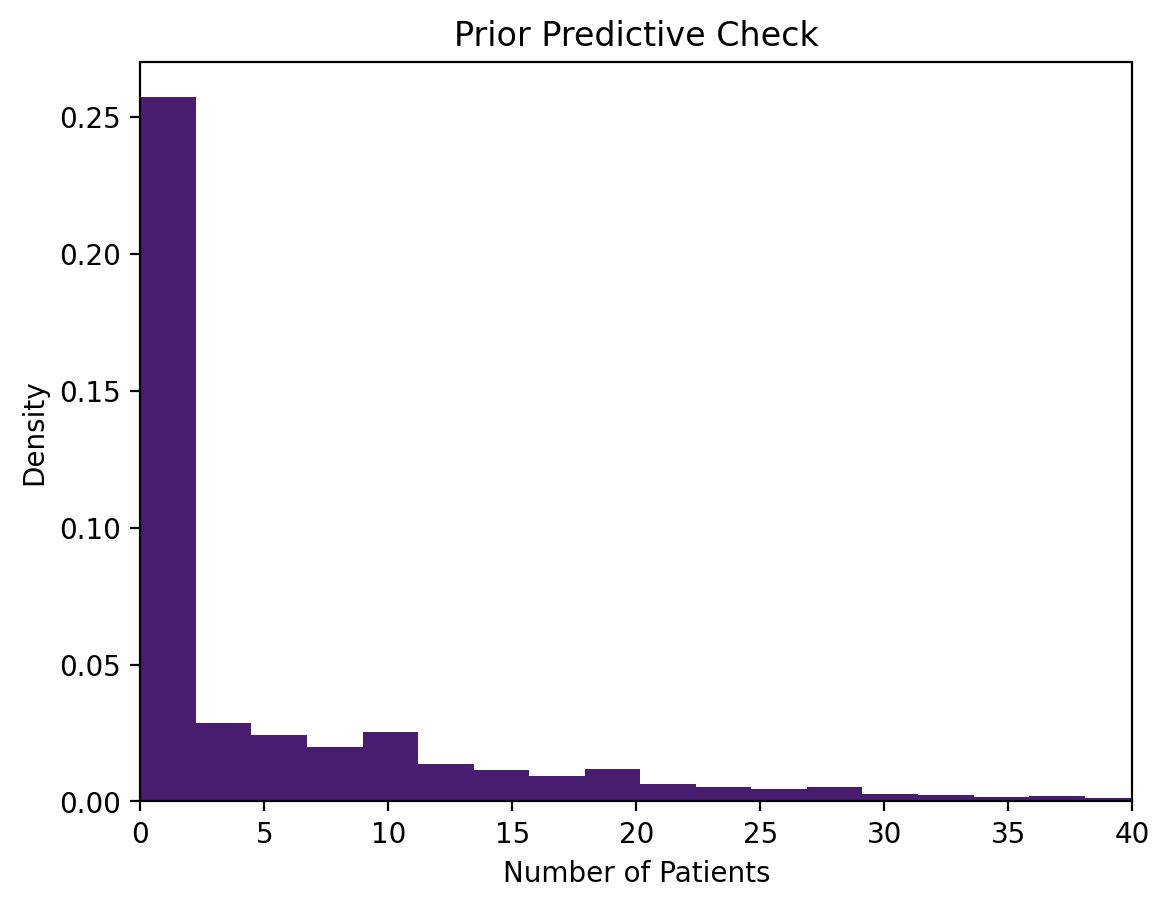

In [22]:
# Extract the likelihood samples
likelihood_samples = idata_h_prior_pred.prior_predictive.score
flattened_array = np.ravel(likelihood_samples.values)

# Plot the prior predictive samples
plt.hist(flattened_array, bins=200, density=True)
plt.xlabel('Number of Patients')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.xlim(0, 40)
plt.show()

In [23]:
with model_h:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:13.758661
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.836857
Transforming variables...
Transformation time =  0:00:00.015640
Computing Log Likelihood...


Log Likelihood time =  0:00:00.219554


In [24]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h_mu,9.60,1.65,6.64,12.55,0.04,0.03,2417.17,1619.84,1.0
h_sigma,3.34,2.04,1.10,6.71,0.05,0.04,2352.31,1999.48,1.0
lam[location_1],9.30,0.55,8.32,10.37,0.01,0.01,4249.06,2727.02,1.0
lam[location_2],6.13,0.45,5.24,6.94,0.01,0.00,4062.75,2944.20,1.0
lam[location_3],9.55,0.55,8.56,10.63,0.01,0.01,3676.12,2833.00,1.0
lam[location_4],8.95,0.53,7.96,9.95,0.01,0.01,4283.04,2829.47,1.0
lam[location_5],11.88,0.64,10.76,13.15,0.01,0.01,3845.57,2825.57,1.0


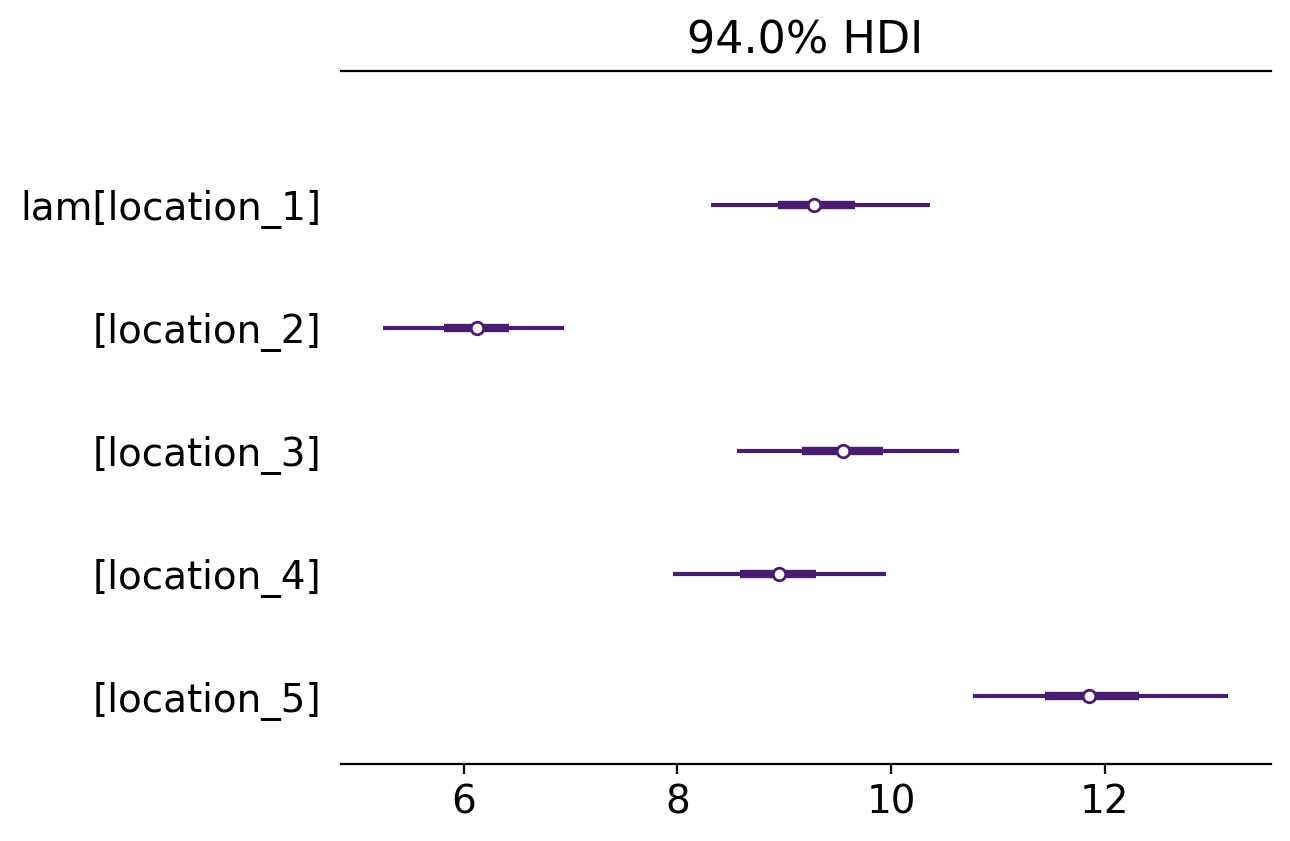

In [25]:
samples_lam = idata.posterior["lam"]
az.plot_forest(samples_lam, combined=True, hdi_prob=0.94)
plt.show()

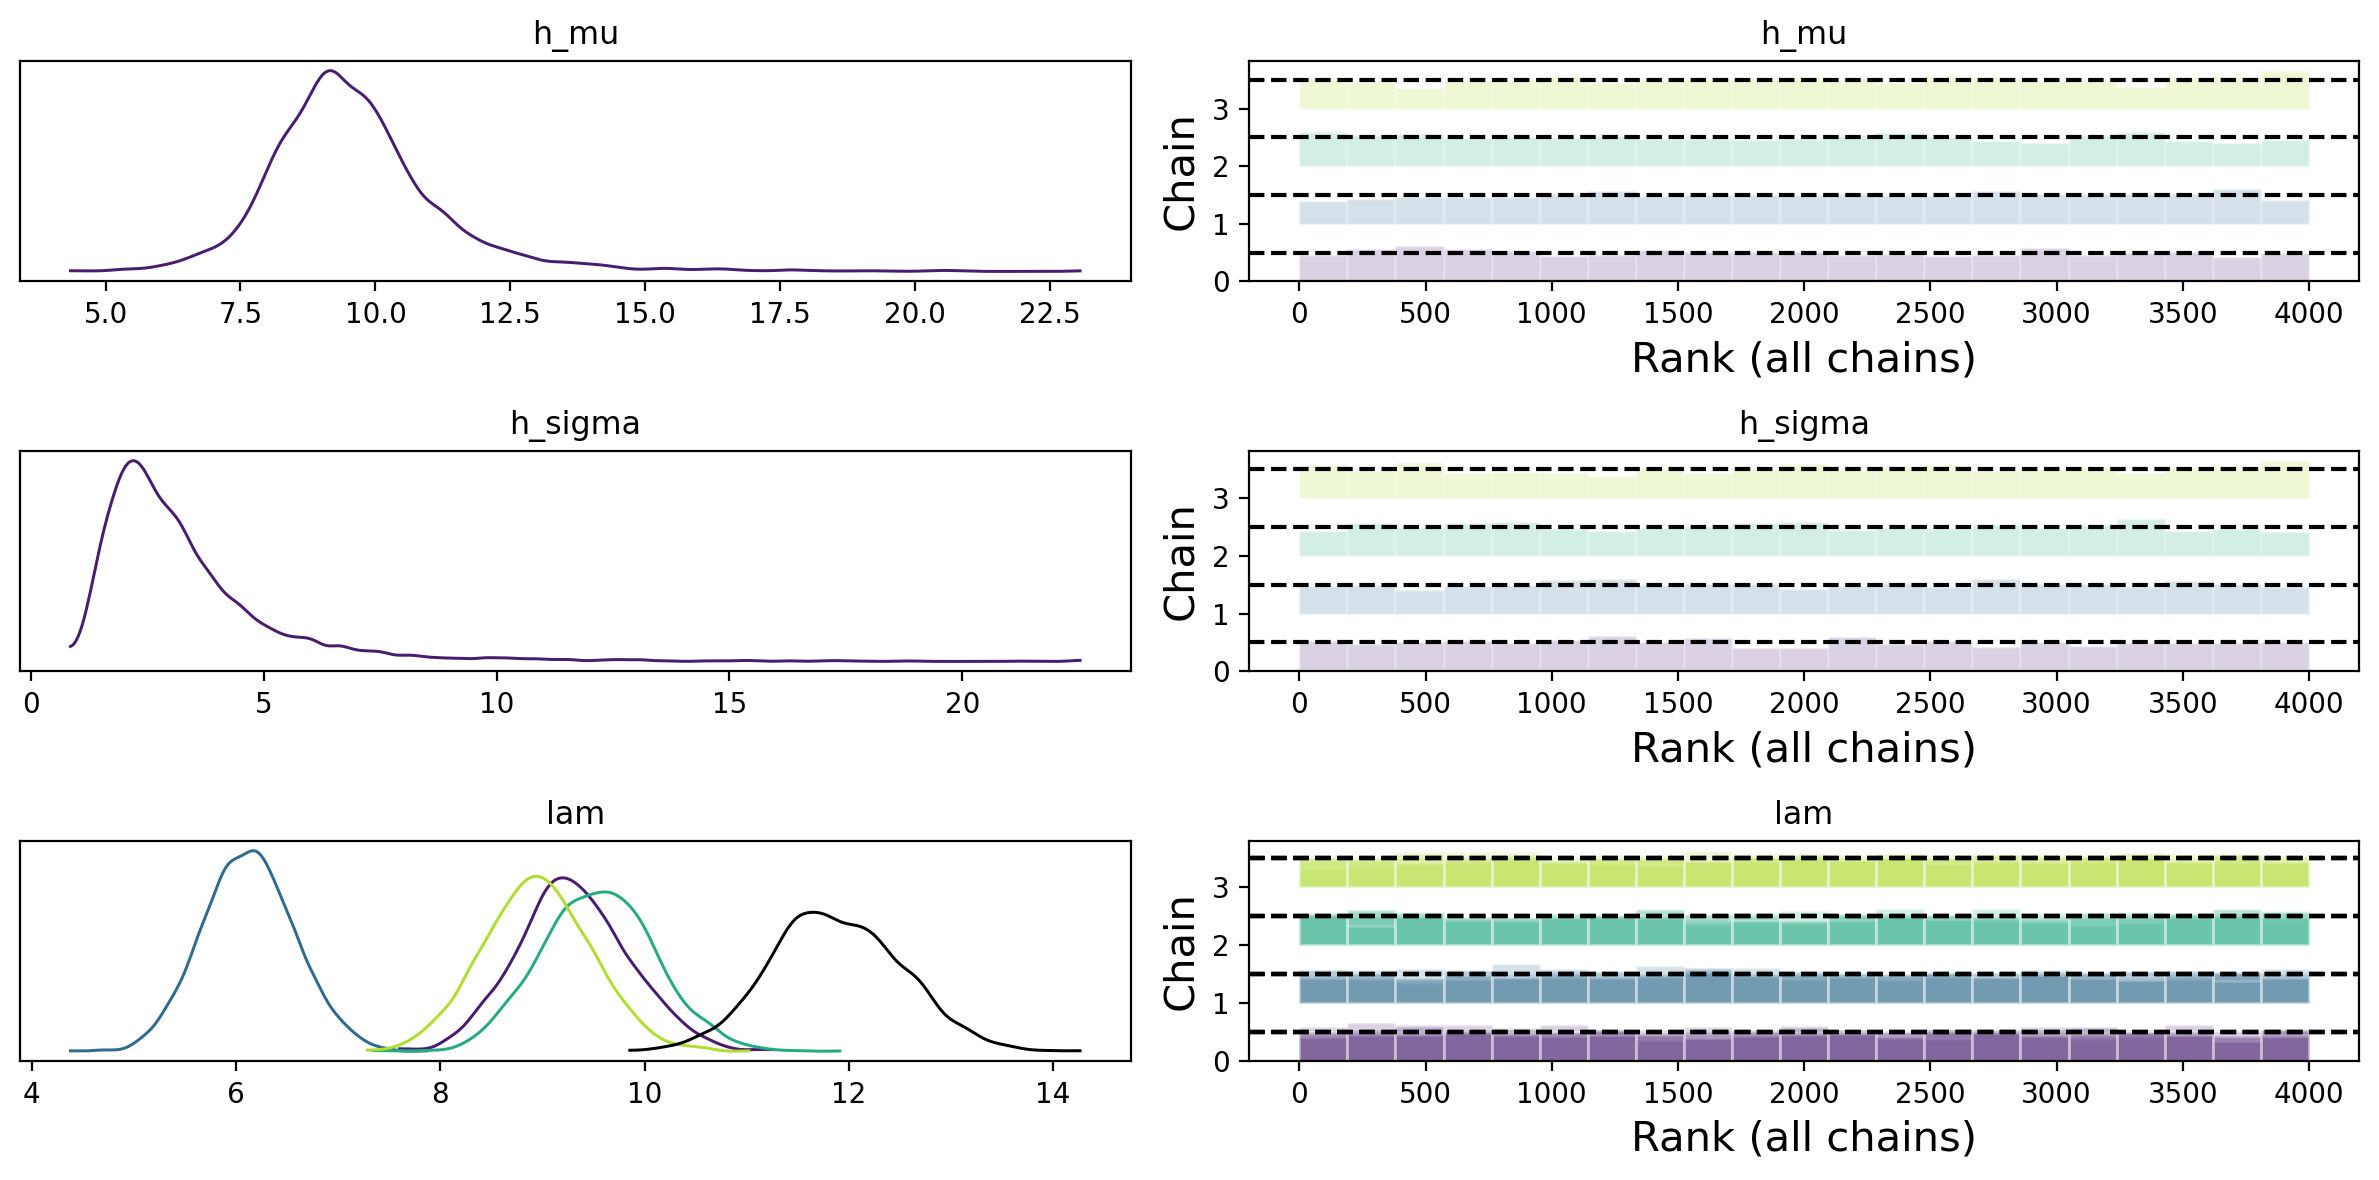

In [26]:
az.plot_trace(idata, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

In [27]:
with model_h:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [score]


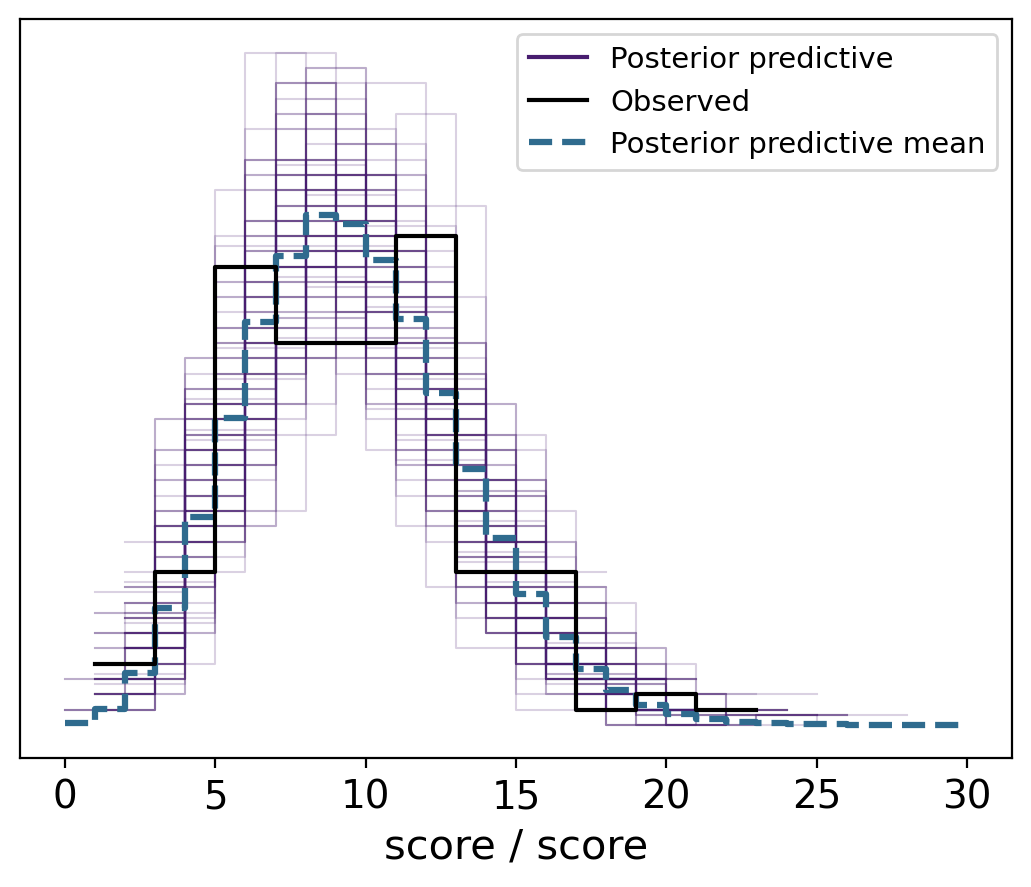

In [28]:
az.plot_ppc(post_pred, num_pp_samples=100)
plt.show()

In [29]:
# Trasformazione del DataFrame in formato long
df_long = dat_wide.melt(var_name="Location", value_name="Value")

In [30]:
df_long["Location_idx"] = df_long["Location"].str.extract("(\d+)").astype(int) - 1
display(df_long)

,Location,Value,Location_idx
0,location_1,12,0
1,location_1,12,0
2,location_1,6,0
3,location_1,13,0
4,location_1,12,0
...,...,...,...
145,location_5,11,4
146,location_5,11,4
147,location_5,19,4
148,location_5,11,4


In [31]:
coords = {
    "obs": np.arange(len(df_long)),
    "location": np.arange(len(df_long['Location'].unique())),
}
coords

{'obs': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149]),
 'location': array([0, 1, 2, 3, 4])}

In [32]:
with pm.Model(coords=coords) as model_h_long:
    # Definizione dei dati
    data = pm.ConstantData("observed_score", df_long["Value"], dims="obs")
    location_idx = pm.ConstantData("location_idx", df_long["Location_idx"], dims="obs")

    # Iperparametri per la distribuzione Gamma
    h_mu = pm.HalfNormal("h_mu", sigma=10)
    h_sigma = pm.HalfNormal("h_sigma", sigma=20)

    # Priori Gamma per ogni località
    lam = pm.Gamma("lam", mu=h_mu, sigma=h_sigma, dims="location")

    # Verosimiglianza Poissoniana per i punteggi
    score = pm.Poisson("score", mu=lam[location_idx], observed=data, dims="obs")

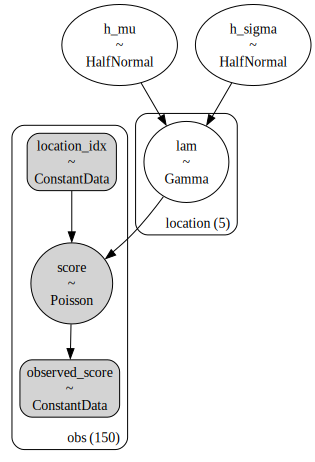

In [33]:
pm.model_to_graphviz(model_h_long)

In [34]:
with model_h_long:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time =  0:00:06.701210
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.730646
Transforming variables...
Transformation time =  0:00:00.006625
Computing Log Likelihood...


Log Likelihood time =  0:00:00.202930


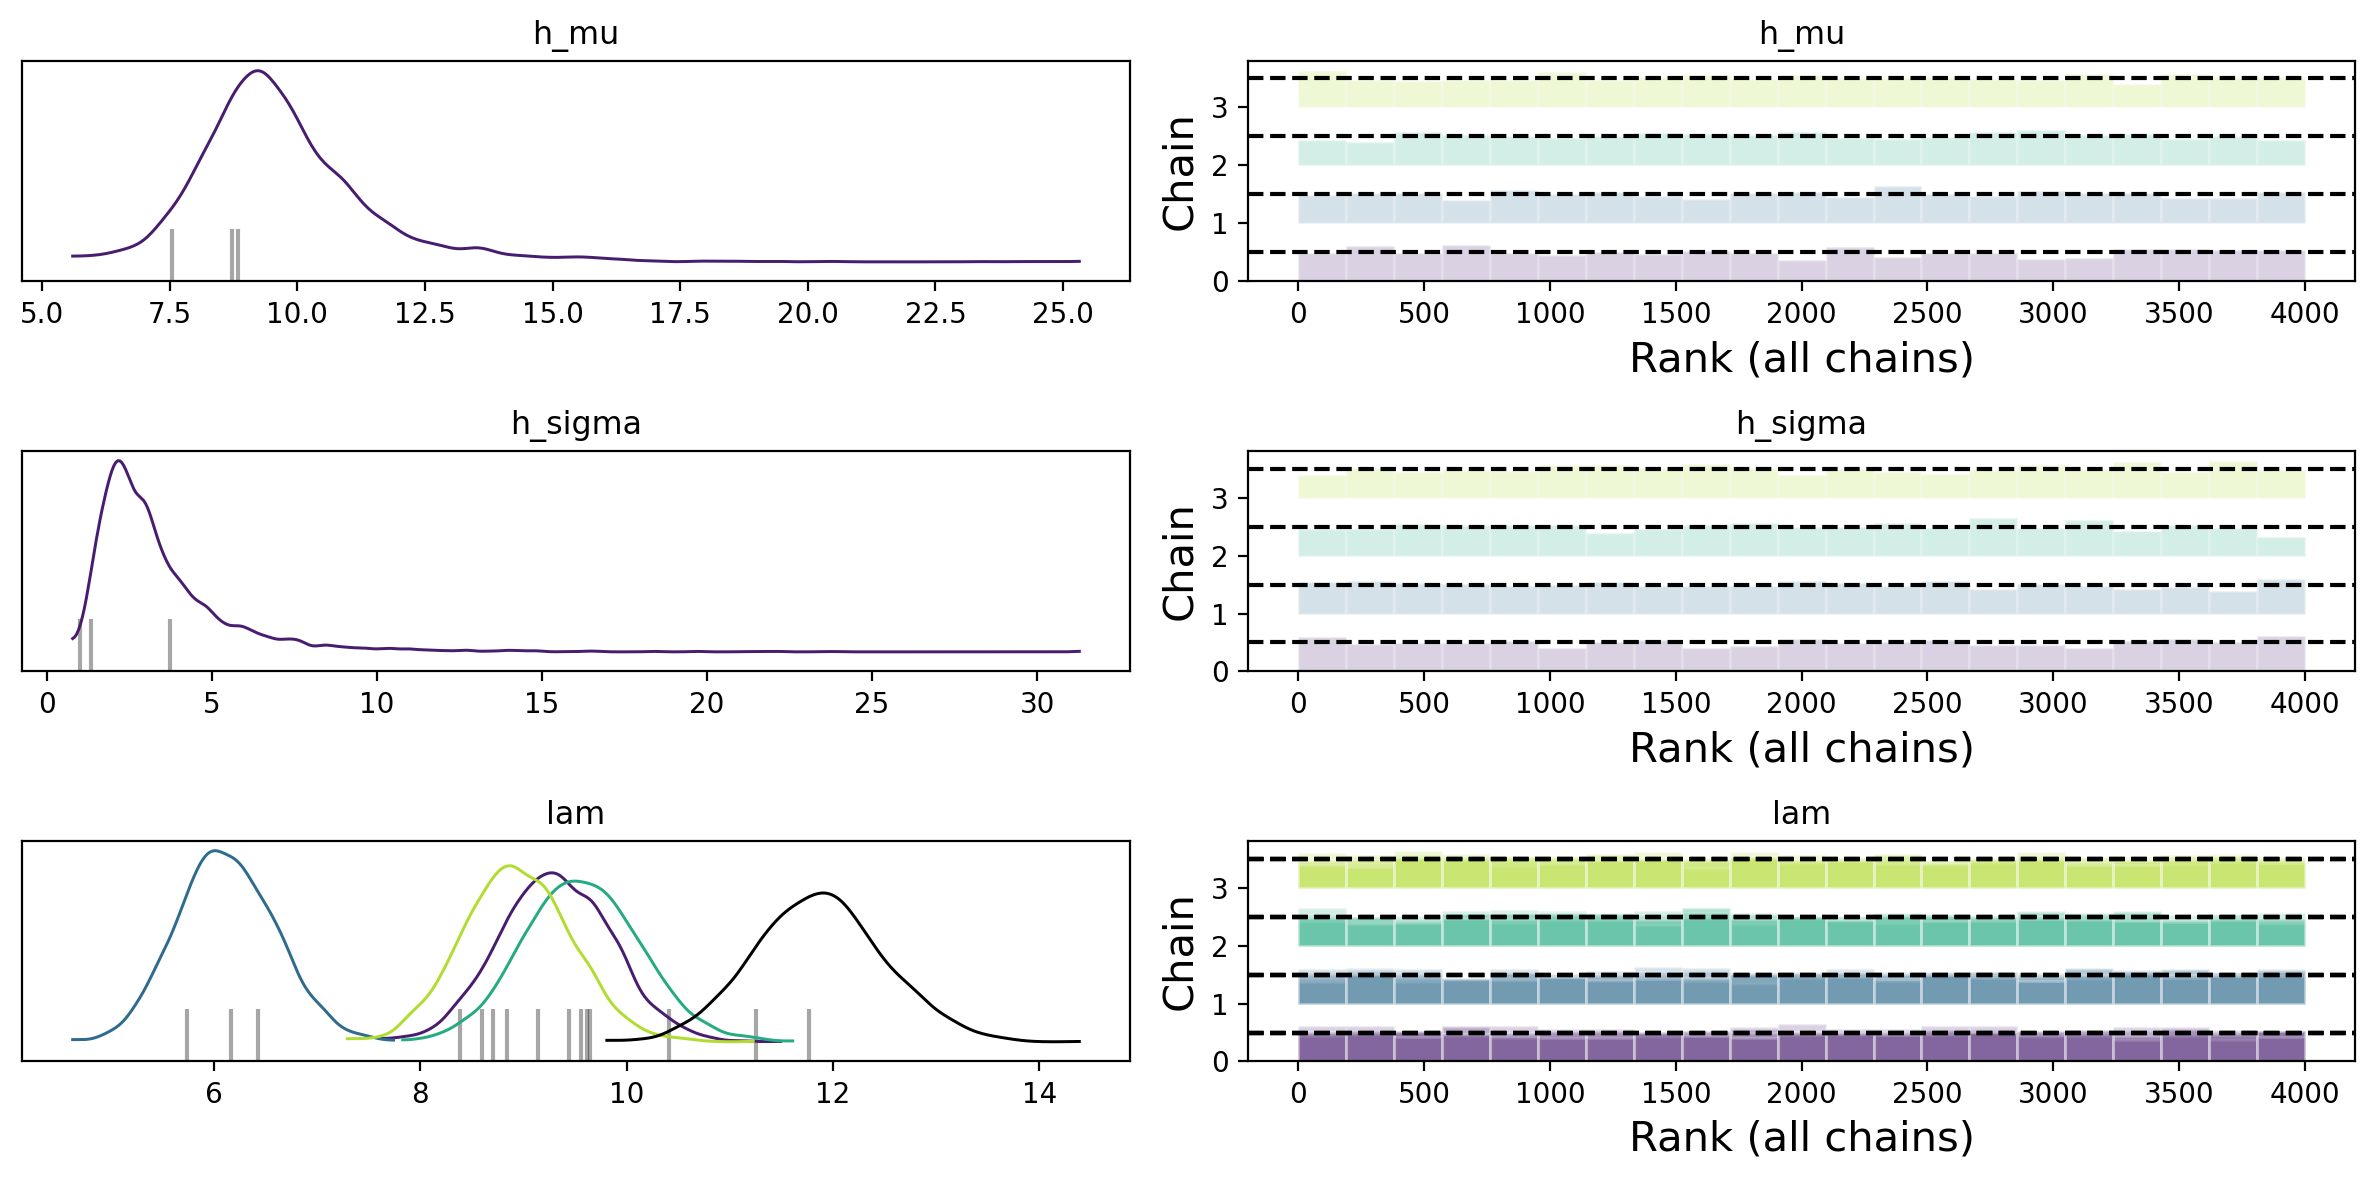

In [35]:
az.plot_trace(idata, combined=True, kind="rank_bars")
plt.tight_layout()

In [36]:
dat_long.head()

,obs,location,patients
0,0,location_1,12
1,1,location_1,12
2,2,location_1,6
3,3,location_1,13
4,4,location_1,12


In [37]:
model_hierarchical = bmb.Model(
    "patients ~ 1 + (1 | location)", dat_long, family="poisson"
)

In [38]:
model_hierarchical_fitted = model_hierarchical.fit(
    draws=2000,
    target_accept=0.85,
    random_seed=RANDOM_SEED,
    method="nuts_numpyro", 
    idata_kwargs={"log_likelihood": True},
)

Compiling...


Compilation time =  0:00:04.869439
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:01.967381
Transforming variables...
Transformation time =  0:00:00.032990
Computing Log Likelihood...


Log Likelihood time =  0:00:00.240640


In [39]:
summary = az.summary(model_hierarchical_fitted)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.182,0.184,1.849,2.564,0.007,0.005,857.0,775.0,1.00
1|location_sigma,0.373,0.226,0.121,0.757,0.010,0.008,905.0,753.0,1.00
1|location[location_1],0.045,0.190,-0.349,0.382,0.007,0.007,885.0,773.0,1.00
1|location[location_2],-0.372,0.192,-0.763,-0.030,0.007,0.005,922.0,859.0,1.00
1|location[location_3],0.071,0.190,-0.308,0.421,0.007,0.006,916.0,818.0,1.01
1|location[location_4],0.006,0.190,-0.365,0.373,0.007,0.006,905.0,831.0,1.00
1|location[location_5],0.291,0.189,-0.064,0.662,0.007,0.006,921.0,785.0,1.00


In [40]:
(
    np.exp(summary["mean"][0] + summary["mean"][2]),
    np.exp(summary["mean"][0] + summary["mean"][3]),
    np.exp(summary["mean"][0] + summary["mean"][4]),
    np.exp(summary["mean"][0] + summary["mean"][5]),
    np.exp(summary["mean"][0] + summary["mean"][6]),
)

(9.272008288824463,
 6.11044743223061,
 9.516241781405718,
 8.917360546987915,
 11.857967446453067)

In [41]:
model_pooling = bmb.Model("patients ~ 1", dat_long, family="poisson")
model_pooling_fitted = model_pooling.fit(
    draws=2000,
    target_accept=0.85,
    random_seed=RANDOM_SEED,
    method="nuts_numpyro", 
    idata_kwargs={"log_likelihood": True},
)

Compiling...


Compilation time =  0:00:01.152354
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:00:01.183825
Transforming variables...
Transformation time =  0:00:00.002787
Computing Log Likelihood...
Log Likelihood time =  0:00:00.147948


In [42]:
summary2 = az.summary(model_pooling_fitted)
summary2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.213,0.027,2.165,2.264,0.0,0.0,3171.0,3617.0,1.0


In [43]:
np.exp(summary2["mean"][0])

9.143104603994704

In [44]:
models = {"hierarchical": model_hierarchical_fitted, "pooling": model_pooling_fitted}
df_compare = az.compare(models)
df_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hierarchical,0,-394.714100,5.814505,0.000000,0.981215,10.667445,0.000000,False,log
pooling,1,-421.936033,1.541919,27.221933,0.018785,13.365812,8.320898,False,log


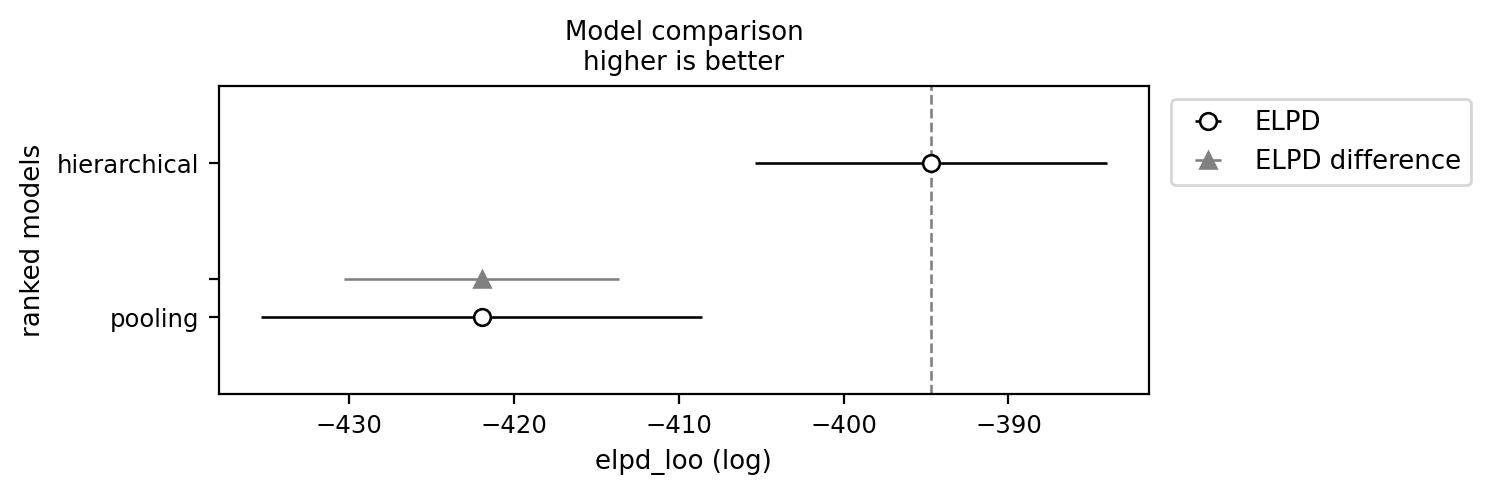

In [45]:
az.plot_compare(df_compare, insample_dev=False)
plt.show()

In [46]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

matplotlib: 3.7.2
pandas    : 2.0.3
numpy     : 1.25.2
bambi     : 0.12.0
pymc      : 5.6.1
arviz     : 0.16.0
seaborn   : 0.12.2
scipy     : 1.10.1

Watermark: 2.4.3

